In [1]:
import numpy as np
from scipy import optimize
from scifit.solvers import FitSolver1D

In [2]:
class Model(FitSolver1D):
    @staticmethod
    def model(x, a, b, c):
        return a * x[:, 0]**2 + b * x[:, 0] + c

In [3]:
model = Model()

In [4]:
data = model.synthetic_dataset(parameters=(3,2,1), sigma=0.1)

In [5]:
sol1 = model.fit(data)

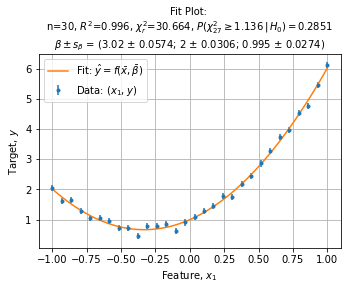

In [6]:
axe = model.plot_fit()

In [7]:
sol1["parameters"]

array([3.01710543, 2.00080084, 0.99472341])

In [8]:
sol1["covariance"]

array([[ 3.29272575e-03, -1.22229183e-11, -1.17327009e-03],
       [-1.22229183e-11,  9.35483859e-04,  8.58959144e-12],
       [-1.17327009e-03,  8.58959144e-12,  7.51395089e-04]])

In [9]:
optimize.curve_fit(Model.model, data[["x0"]].values, data["y"].values)

(array([3.01710543, 2.00080084, 0.99472341]),
 array([[ 3.73959710e-03,  2.31468658e-11, -1.33250012e-03],
        [ 2.31468658e-11,  1.06244278e-03, -1.26854872e-11],
        [-1.33250012e-03, -1.26854872e-11,  8.53370462e-04]]))

In [10]:
optimize.curve_fit(Model.model, data[["x0"]].values, data["y"].values, sigma=data["sy"].values)

(array([3.01710543, 2.00080084, 0.99472341]),
 array([[ 3.73959707e-03, -1.38817481e-11, -1.33250010e-03],
        [-1.38817481e-11,  1.06244278e-03,  9.75532535e-12],
        [-1.33250010e-03,  9.75532535e-12,  8.53370455e-04]]))

In [11]:
popt, pcov = optimize.curve_fit(Model.model, data[["x0"]].values, data["y"].values, sigma=data["sy"].values, absolute_sigma=True)
pcov

array([[ 3.29272575e-03, -1.22229183e-11, -1.17327009e-03],
       [-1.22229183e-11,  9.35483859e-04,  8.58959144e-12],
       [-1.17327009e-03,  8.58959144e-12,  7.51395089e-04]])

In [12]:
def loss_factory(x, y, sigma=1.):
    def wrapped(beta):
        return 0.5*np.sum(np.power((y - Model.model(x, *beta)) / sigma, 2))
    return wrapped

In [13]:
loss = loss_factory(data[["x0"]].values, data["y"].values, sigma=data["sy"].values)

In [14]:
sol09 = optimize.minimize(loss, x0=[1, 1, 1])
sol09

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 15.332148569156821
        x: [ 3.017e+00  2.001e+00  9.947e-01]
      nit: 5
      jac: [ 3.576e-07 -4.768e-07  0.000e+00]
 hess_inv: [[ 3.293e-03  1.252e-11 -1.173e-03]
            [ 1.252e-11  9.355e-04 -1.070e-12]
            [-1.173e-03 -1.070e-12  7.514e-04]]
     nfev: 32
     njev: 8

In [15]:
sol09.hess_inv - pcov

array([[ 3.38611647e-11,  2.47398450e-11, -2.50924164e-11],
       [ 2.47398441e-11,  5.86163778e-12, -9.65967309e-12],
       [-2.50924164e-11, -9.65967341e-12,  1.25870064e-11]])

In [16]:
pcov

array([[ 3.29272575e-03, -1.22229183e-11, -1.17327009e-03],
       [-1.22229183e-11,  9.35483859e-04,  8.58959144e-12],
       [-1.17327009e-03,  8.58959144e-12,  7.51395089e-04]])

In [17]:
sol10 = optimize.minimize(loss, x0=[1, 1, 1], method="L-BFGS-B")
sol10

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 15.332148569156754
        x: [ 3.017e+00  2.001e+00  9.947e-01]
      nit: 9
      jac: [-6.573e-06 -4.441e-06 -1.776e-06]
     nfev: 40
     njev: 10
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [18]:
sol10.hess_inv.todense()

array([[ 0.00559644, -0.00059923, -0.00195969],
       [-0.00059923,  0.00116968,  0.00026955],
       [-0.00195969,  0.00026955,  0.00107388]])

In [19]:
def residuals_factory(x, y, sigma=1.):
    def wrapped(beta):
        return (y - Model.model(x, *beta))/sigma
    return wrapped

In [20]:
residuals = residuals_factory(data[["x0"]].values, data["y"].values, sigma=data["sy"].values)

In [21]:
sol2 = optimize.least_squares(residuals, x0=[1, 1, 1])

In [22]:
U, s, Vh = np.linalg.svd(sol2.jac, full_matrices=False)
tol = np.finfo(float).eps*s[0]*max(sol2.jac.shape)
w = s > tol
cov = (Vh[w].T/s[w]**2) @ Vh[w]

In [23]:
cov

array([[ 3.29272573e-03,  5.10999583e-14, -1.17327009e-03],
       [ 5.10999583e-14,  9.35483875e-04,  6.78502888e-13],
       [-1.17327009e-03,  6.78502888e-13,  7.51395090e-04]])

In [24]:
pcov

array([[ 3.29272575e-03, -1.22229183e-11, -1.17327009e-03],
       [-1.22229183e-11,  9.35483859e-04,  8.58959144e-12],
       [-1.17327009e-03,  8.58959144e-12,  7.51395089e-04]])

In [25]:
sol3 = optimize.leastsq(residuals, x0=[1, 1, 1], full_output=True)

In [26]:
sol3

(array([3.01710543, 2.00080084, 0.99472341]),
 array([[ 3.29272567e-03, -1.47421387e-11, -1.17327007e-03],
        [-1.47421387e-11,  9.35483860e-04,  6.93681766e-12],
        [-1.17327007e-03,  6.93681766e-12,  7.51395091e-04]]),
 {'fvec': array([ 0.36115516, -1.27902788,  1.36525545, -0.36112989, -0.75172036,
          0.87175052,  0.85826806, -0.62537895,  0.03767869, -2.21149203,
          1.18881211,  1.03667871,  1.00238597, -1.96949097, -0.28123867,
          0.05440476,  0.45556035,  0.33539228,  1.36202477, -1.51309988,
         -0.17752871, -0.64116694,  0.19628142,  0.54272944,  1.29224541,
         -0.51203524,  0.61437316, -1.89828628, -0.28607286,  0.93267244]),
  'nfev': 9,
  'fjac': array([[ 5.47722554e+01,  1.82574185e-01,  1.82574185e-01,
           1.82574185e-01,  1.82574185e-01,  1.82574187e-01,
           1.82574187e-01,  1.82574187e-01,  1.82574187e-01,
           1.82574185e-01,  1.82574188e-01,  1.82574187e-01,
           1.82574187e-01,  1.82574187e-01,  1.825